# Solving the Traveling Salesman Problem in Python and C++ using the ROOT framework

##### Abstract
In this document we are going to show how to develop an Ant Colony Optimization algorithm for solving the TSP using the data analysis software package by CERN, ROOT. The interface is in python to keep things simple but the logic is in C++.

## Key Benefits of this work

* Test the ROOT framework capabilities when working with Python and C++
* Demonstrate how to solve the Traveling Salesman Problem with important applications in science and engineering
* Demonstrate how to implement the Ant Colony Metaheuristic to get near optimal solutions for the Traveling Salesman Problem fast in Modern C++
* Show how Python and C++ can be combined to have easy interfaces and fast solutions


## Introduction

Imagine that you are a salesman and you want to visit all your customers once and return to your home. In order to save costs as much as possible you would want to find the shortest possible route that visits each customer exactly once and returns to your starting point. This is exactly what is studied in **The Traveling Salesman Problem (TSP)**.

TSP has numerous other applications even in seemingly different domains like *X-Ray crystallography*. In this application studied in (Bland & Shallcross, 1989), there is an X-ray diffractometer that is used to to obtain information about the structure of the crystalline material. The diffractometer has 4 motors for moving and needs to be positioned in various positions, sometimes hundreds of thousands. The time to move from position to position can be computed quite accurately. The sequence of the positions does not influence the end result, however, it influcences the time taken to complete the experiment. The problem of minimizing positioning time is essentially the traveling salesman problem. 


## Ant Colony Optimization for TSP

The Traveling Salesman Problem is *NP-Hard* which means that in order to solve it exactly, an exponential amount of time is needed and it is impractical for problems with a large number of nodes and that is why many approximation and heuristic algorithms have been suggested to find solutions.

In this document we will discuss and develop and *Ant Colony Optimization*(**ACO**) algorithm in order to find solutions for the TSP. It should be emphasized that ACO is a *metaheuristic* algorithm which implies that there is no guarantee that it will find the optimal solution in a reasonable amount of time, but it will find at least a very good one in a very short amount of time.

ACO imitates nature and more specifically the movement of ants in order to find good quality solutions fast. Ants when they move they leave a pheromone trail behind them and their purpose is to find food and return to their nest. The consequence of that is that the shortest paths have more pheromone laid over them since pheromone evaporates as time passes and for the longest paths evaporates more. Additionally, each ant is attracted with high probability to follow trails with more pheromone but with a small probability can follow its own path. Therefore, over time most ants converge to the shortest found path and some of the ants always explore for new shorter paths.

In the following picture we can see 2 ants that begin from the same source going to the same destination, but they choose different paths. The one that selected the shortest path will return find the destination and return to the source faster. Consequently, it will have completed 2 tours from the same path before the ant that selected the longer path and that path will have more pheromone on it, attracting more of the subsequent ants searching for food.


![Ant Colony, the upper path will have more pheromone](ant_colony.png)


Welcome to ROOTaaS 6.06/00


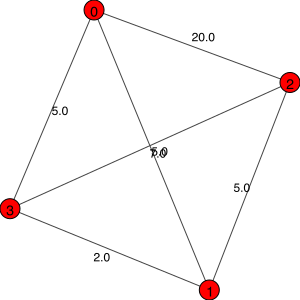

In [1]:
# In this piece of code we load the necessary packages, ROOT, igraph
# We also define vector2d_from_list which transforms a python list of lists
# to a C++ vector
# Additionally, we create a toy graph of cities represented by distgraph
# and we visualize it using igraph

from __future__ import division

import ROOT
import igraph

distgraph = [
    [0,5,20,5],
    [5,0,5,2],
    [20,5,0,7],
    [5,2,7,0]
]

from ROOT import std

dg = std.vector('std::vector<double>')()

def vector2d_from_list(lst):
    ret = std.vector('std::vector<double>')()
    for row in distgraph:
        temp = std.vector('double')()
        for col in row:
            temp.push_back(col)
        ret.push_back(temp);
    return(ret)
        

g = igraph.Graph.Weighted_Adjacency(distgraph, mode = igraph.ADJ_MAX, loops = False, attr = "weight")
g.vs['label'] = range(len(distgraph))
igraph.plot(g, labels = True, edge_label=g.es["weight"], bbox = (300,300), margin = 10)

In [3]:

%%cpp

std::cout << "This statement is needed for C++ to work subsequently" << std::endl;

This statement is needed for C++ to work subsequently


In [4]:

%%cpp -d
// Here define a function that prints a 2d C++ vector
// and we test it using distgraph (we transform it to C++ and print it)
// The "cpp -d" magic is provided by ROOT to have C++ in the notebook
void print_vector2d(const std::vector<std::vector<double> >& v)
        {
            for (const auto& row:v){
                for (const auto& col:row) {
                    std::cout << col << " ";
                }
                std::cout << endl;
            }
        }

In [5]:
ROOT.print_vector2d(vector2d_from_list(distgraph))

0 5 20 5 
5 0 5 2 
20 5 0 7 
5 2 7 0 


In [6]:
# Here we define the initial value of the
# pheromone (the attraction factor) as
# inversely proposional to the size of our graph
# (the number of our cities)
init_pherom = 1/len(distgraph)

In [7]:
# Here we initialize the pheromone matrix to the initial
# value of the pheromone
pheromones = [
    [(init_pherom if x!=y else 0.0) for x in range(len(distgraph))] 
              for y in range(len(distgraph))
]

In [8]:
pheromones

[[0.0, 0.25, 0.25, 0.25],
 [0.25, 0.0, 0.25, 0.25],
 [0.25, 0.25, 0.0, 0.25],
 [0.25, 0.25, 0.25, 0.0]]

In [9]:
pheromones


[[0.0, 0.25, 0.25, 0.25],
 [0.25, 0.0, 0.25, 0.25],
 [0.25, 0.25, 0.0, 0.25],
 [0.25, 0.25, 0.25, 0.0]]

## Ant Logic

Each ant selects the arc to follow with the following probability $$p_{ij}=\frac{\eta_{ij}^\beta \tau_{ij}^\alpha}{\sum\limits_{k}\eta_{ij}^\alpha \tau_{ij}^\beta}$$

where<br>
      $p_{ij}$ is the probability to select the edge $(i,j)$<br>
      $\eta_{ij}$ is a heuristic function for edge $(i,j)$<br>
      $\tau_{ij}$ is the pheromone of edge $(i,j)$<br>
      $\alpha$ is the weight we give to the pheromone<br>
      $\beta$ is the weight we give to the heuristic function<br>
      
Here as a heuristic we use the inverse of distance $\eta_{ij}=\frac{1}{d_{ij}}$
          
Here we define the settings as a list with [$\alpha$, $\beta$, $\rho$, QVAL]. 
The parameters that we use from experimental evidence are $\alpha$ = 1.0, $\beta$ = 5.0, $\rho$ = 0.5, $QVAL$ = 100.
The last 2 parameters will be explained in a next section

In [10]:
%%cpp -d
#include <vector>
#include <cmath>
#include <random>
#include <cassert>

/**
 This class represents the logic for the movement of an ant
 An Ant needs to be provided:
 the city from which it will start (initCity)
 the pheromones (pheromones)
 the distance matrix that represents the graph of the cities (distgraph)
 
 After the ant has run (Ant::run)
 we can get:
 the path that it followed (builtPath)
 the length of the path (tourLength)
*/
class Ant {
    int initCity;
    std::vector<std::vector<double> >* pheromones;
    std::vector<std::vector<double> >* dist;
    std::vector<unsigned char> visited{};

public:
    std::vector<double> settings{1.0, 5.0, 0.5, 100};
    double tourLength;
    std::vector<int> builtPath{};

    int getInitCity() const
    {
        return initCity;
    }

    void setInitCity(int initCity)
    {
        Ant::initCity = initCity;
        std::fill(std::begin(visited), std::end(visited), 0);
        visited[initCity] = 1;
    }

    Ant(int city, std::vector<std::vector<double> >* pherom, std::vector<std::vector<double> >* distgraph)
            :initCity(city), pheromones(pherom), dist(distgraph)
    {
        visited.resize(dist->size());
        visited[city] = 1;
    }

    /**
    This function returns the probability that the Ant will follow the edge (from, to)
    */
    double prob(int from, int to)
    {
        double nom = (std::pow(1/(*dist)[from][to], settings[1])*std::pow((*pheromones)[from][to], settings[0]));
        double denom = 0.0;
        for (int i = 0; i<visited.size(); ++i) {
            if (visited[i]==0) {
                denom += (std::pow(1/(*dist)[from][i], settings[1])*std::pow((*pheromones)[from][i], settings[0]));
            }
        }
        if (denom>0.00001) {
            return nom/denom;
        }
        else {
            return 1.0;
        }
    }

    /**
    Here is the main logic of the ant
    It builds a path according to the probability defined above prob(from, to)
    After running it, builtPath contains the indexes of the nodes visited and
    tourLength its length
    */
    double run()
    {
        int visitNum = 0;
        int size = dist->size();
        int curCity = initCity;
        std::random_device rand;
        double tourLen = 0.0;
        visited.clear();
        visited.resize(size);
        visited[curCity] = 1;
        builtPath.clear();
        builtPath.resize(size);
        builtPath[visitNum] = curCity;
        while (visitNum<(size-1)) {

            double probNum;
            double visitProb;
            int index;

            index = curCity;
            do {
                ++index;
                if (index>=size) {
                    index = 0;
                }
                if (visited[index]) {
                    visitProb = 0;
                }
                else {
                    visitProb = prob(curCity, index);
                }
                probNum = static_cast<double>(rand())/rand.max();
            }
            while (probNum>visitProb);
            tourLen += (*dist)[curCity][index];
            curCity = index;
            visited[index] = 1;
            visitNum++;
            builtPath[visitNum] = curCity;
        }
        tourLen += (*dist)[curCity][initCity];
        tourLength = tourLen;
        return tourLen;
    }

};

## Ant Colony Optimization (ACO) logic

The Ant Colony Optimization that we use here places ants in each node of the graph and lets them build their paths. Then it updates the pheromones of the edges.

Each ant $k$ contributes $$\Delta\tau_{ij}^k(t) = \frac{QVAL}{L^k(t)}$$ pheromone, where $QVAL$ is a parameter that in our case we have set to 100 and $L^k(t)$ is the tour length of ant $k$.

The actual update of the pheromone $\tau_{ij}$ on edge $(i,j)$ allowed by ACO is $$\tau_{ij}=\tau_{ij}+(\Delta\tau_{ij}^k(t) * \rho)$$ where $\rho$ is a parameter between 0.0 and 1.0 that controls the amount of evaporation and the strength of the previous parameter. Finally, the pheromones evaporate according to the equation $$\tau_{ij} = \tau_{ij}*(1-\rho)$$

In [11]:

%%cpp -d

/**
This class implements the main logic of the Ant Colony Optimization (ACO)
The user can set the settings in the order (alpha, beta, rho, QVAL).
The graph in the format of a distance matrix (distgraph) must be provided, and also
the user can set the number of iterations and the number of ants used. If the number
of iterations is not set, 10 iterations are done and if the ants are not provided, ants
equal to the number of nodes are used.

After ACO is ran (ACO::run) we can retrieve the best path (getBestPath)
and the cost (bestCost)
*/
class ACO {
private:
    std::vector<std::vector<double> > dist;
    std::vector<std::vector<double> > pheromones{{}};

    std::vector<int> bestPath{};
public:
    std::vector<double> settings{1.0, 5.0, 0.5, 100};
    int numAnts = -1;
    int maxIter;
    double bestCost;

    const std::vector<int>& getBestPath() const
    {
        return bestPath;
    }

    ACO(std::vector<std::vector<double> > distgraph, int iters = 10, int numAnt = -1)
            :dist(distgraph), numAnts(numAnt), maxIter(iters) { if (numAnt==-1) numAnts = dist.size(); }

    /**
    Here the main logic is implemented
    First the pheromones are initialized with init_pheromone value
    and then we place one ant in each city and we let them
    build their paths. Afterwards we update the pheromones and
    finally evaporate them
    */
    double run()
    {
        double size = dist.size();
        assert(size>0);
        double init_pheromone = 1/size;
        pheromones.resize(size);
        for (int i = 0; i<size; ++i) {
            pheromones[i].resize(size);
        }
        for (int i = 0; i<size; ++i) {
            for (int j = i+1; j<size; ++j) {
                pheromones[i][j] = init_pheromone;
                pheromones[j][i] = init_pheromone;
            }
        }
        bestCost = std::numeric_limits<double>::max();

        for (int i = 0; i<maxIter; ++i) {
            std::vector<Ant> ants(numAnts, {0, &pheromones, &dist});
            int index = 0;
            // Run ants
            for (auto& ant:ants) {
                ant.setInitCity(index);
                ant.settings = settings;
                double curCost = ant.run();
                if (curCost<=bestCost) {
                    bestCost = curCost;
                    bestPath = ant.builtPath;
                }
                if (++index>=size) index = 0;
            }
            // Update pheromones
            for (const auto& ant:ants) {
                for (int i = 0; i<size; ++i) {
                    int from = i;
                    int to = i + 1;
                    if ((i+1) == size) {
                        to = 0;
                    }
                    int antFrom = ant.builtPath[from];
                    int antTo = ant.builtPath[to];
                    pheromones[antFrom][antTo] += (settings[2] * (settings[3]/ant.tourLength));
                    pheromones[antTo][antFrom] = pheromones[antFrom][antTo];
                }
            }

            // Evaporate
            for (int i = 0; i<size; ++i) {
                for (int j = 0; j<size; ++j) {
                    pheromones[i][j] *= settings[2];
                }
            }
        }
        return bestCost;

    }


};

In [12]:
aco = ROOT.ACO(vector2d_from_list(distgraph), 100)

In [13]:
c = aco.run()

In [14]:
aco.bestCost

22.0

In [15]:
p = aco.getBestPath()

In [16]:
print p


<ROOT.vector<int> object at 0x7faf26b3edd0>


In [17]:
p[0]

1

In [18]:
list(p)

[1, 2, 3, 0]

In [19]:
print list(p)

[1, 2, 3, 0]


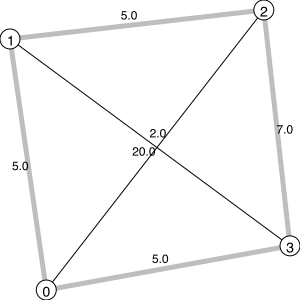

In [20]:
# Here we highlight with gray the shortest tour found using igraph
g.es["color"] = "black"
g.es["width"] = 1
g.vs["color"] = "white"
path = list(p)

# Here we change the color and width of the selected edges before plotting them
for i in range(len(path)):
    src = i
    dst = i + 1
    if dst == (len(path)):
        dst = 0
    edge = (path[src], path[dst]) if path[src] < path[dst] else (path[dst], path[src])
    index = g.get_edgelist().index(edge)
    g.es[index]["color"] = "gray"
    g.es[index]["width"] = 5

igraph.plot(g, labels = True, edge_label=g.es["weight"], bbox = (300,300), margin = 10)

## References
Bland, R.E., & D.E Shallcross (1989). Large traveling salesman problem arising from experiments in X-ray crystallography: a preliminary report on computation. Operations Research Letters, Vol. 8(3), pp. 125-128.

Dorigo, M. & Gambardella, L.M. (1996). “Ant Colonies for the Traveling Salesman Problem”, University Libre de Bruxelles, Belgium.